In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


In [2]:
import numpy as np

import os
from numpy import *
import decoding 
import analysis
import training


In [3]:

period_size = 150
step_size = 50
median_q_threshold=0.5
lower_q_threshold=0.1
upper_q_threshold=0.9
anomaly_res =[15,11]


In [4]:


class Swish(Layer):
    def __init__(self, beta, **kwargs):
        super(Swish, self).__init__(**kwargs)
        self.beta = K.cast_to_floatx(beta)
        print('beta',self.beta)

    def call(self, inputs):
        print('beta', self.beta,'input',input)
        return K.softsign(inputs) * self.beta

    def get_config(self):
        config = {'beta': float(self.beta)}
        base_config = super(Swish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


def intersection(lst1, lst2):
    lst3=[]
    for itr in range(len(lst1)):
        if lst1[itr][0] in lst2:
            lst3.append(lst1[itr])
    return lst3



def verify_stationarity(dataset):
    is_stationary=True
    test_results = adfuller(dataset)

    print(f"ADF test statistic: {test_results[0]}")
    print(f"p-value: {test_results[1]}")
    print("Critical thresholds:")

    for key, value in test_results[4].items():
        print(f"\t{key}: {value}")
    itr = 0
    for key, value in test_results[4].items():
       print('\t%s: %.3f' % (key, value))
       if itr==0:
         critical=value
       itr=itr+1

    print('critical',critical)
    if test_results[0] > critical:
         print('non stationary')
         is_stationary=False
    return  is_stationary

def create_dataset(dataset, look_back=1, tw=3):
    dataX, dataY = [], []  # dtaset for mean
    dataUpperX, dataUpperY = [], []  # dataset for std
    dataLowerX, dataLowerY = [], []  # dataset for mean and std for third deep learning
    multi = look_back // tw
    for i in range(len(dataset) - look_back - 1):
        q50X = []
        q90X =  []
        q10X = []
        a = dataset[i + 1:(i + look_back + 1)]
        indices = i + (multi - 1) * tw
        # print('last window', dataset[indices:(i + look_back), 0])
        c = numpy.quantile(a, median_q_threshold)
        u = numpy.quantile(a, upper_q_threshold)
        l = numpy.quantile(a, lower_q_threshold)
        for j in range(0, len(a), tw):
            q50 = numpy.quantile(a[j:j + tw], median_q_threshold)
            q90 = numpy.quantile(a[j:j + tw], upper_q_threshold)
            q10 = numpy.quantile(a[j:j + tw], lower_q_threshold)
            q50X.append(q50)
            q90X.append(q90)
            q10X.append(q10)
        dataX.append(q50X)
        dataY.append(c)
        dataUpperX.append(q90X)
        dataUpperY.append(u)
        dataLowerX.append(q10X)
        dataLowerY.append(l)

    
    return numpy.array(dataX), numpy.array(dataY), numpy.array(dataUpperX), numpy.array(dataUpperY), numpy.array(dataLowerX), numpy.array(dataLowerY)

def identify_anomaly_quantiles(prediction_errors):
    anomaly_detection=[]
    for m in range(0, len(prediction_errors), period_size):
        period_prediction_errors=prediction_errors[m:m + period_size]
        upper_threshold = numpy.quantile(prediction_errors[m:m + period_size],0.9)
        lower_threshold = numpy.quantile(prediction_errors[m:m + period_size],0.1)
        #upper_threshold=avg+2*std1
        #lower_threshold = avg - 2 * std1
        for i in range(len(period_prediction_errors)):
            if (period_prediction_errors[i]>0 and period_prediction_errors[i]> upper_threshold) or (period_prediction_errors[i]<0 and period_prediction_errors[i]< lower_threshold):
                anomaly_detection.append(period_prediction_errors[i])

    return anomaly_detection

def identify_anomaly(prediction_errors):
    anomaly_detection=[]
    for m in range(0, len(prediction_errors), period_size):
        period_prediction_errors=prediction_errors[m:m + period_size]
        avg = numpy.average(prediction_errors[m:m + period_size])
        std1 = numpy.std(prediction_errors[m:m + period_size])
        upper_threshold=avg+2*std1
        lower_threshold = avg - 2 * std1
        for i in range(len(period_prediction_errors)):
            if (period_prediction_errors[i]> upper_threshold) or ( period_prediction_errors[i]< lower_threshold):
                anomaly_detection.append(period_prediction_errors[i])


    return  anomaly_detection

def identify_alpha(dataset):
    alpha_detection=[]
    alpha=1
    prev_slope=1
    for m in range(0, len(dataset), period_size):
        period_dataset=dataset[m:m + period_size]
        slope=period_dataset[len(period_dataset)-1]-period_dataset[0]
        slope=slope/period_size
        alpha=slope/prev_slope
        alpha_detection.append(alpha)
        prev_slope=slope

    return  numpy.absolute(numpy.mean(alpha_detection))

ADF test statistic: -22.068084141013706
p-value: 0.0
Critical thresholds:
	1%: -3.4341094501874854
	5%: -2.8632005876775297
	10%: -2.567654048515701
	1%: -3.434
	5%: -2.863
	10%: -2.568
critical -3.4341094501874854
dataset [[62.]
 [56.]
 [65.]
 ...
 [62.]
 [64.]
 [64.]]
ADF test statistic: -22.068084141013706
p-value: 0.0
Critical thresholds:
	1%: -3.4341094501874854
	5%: -2.8632005876775297
	10%: -2.567654048515701
	1%: -3.434
	5%: -2.863
	10%: -2.568
critical -3.4341094501874854
[[0.78333336 0.77500004 0.7666667 ]
 [0.78333336 0.77500004 0.7666667 ]
 [0.78333336 0.77500004 0.7666667 ]
 ...
 [0.78333336 0.78333336 0.7666667 ]
 [0.78333336 0.78333336 0.7666667 ]
 [0.78333336 0.78333336 0.7666667 ]]
alpha inf
[[[0.78333336]
  [0.77500004]
  [0.7666667 ]]

 [[0.78333336]
  [0.77500004]
  [0.7666667 ]]

 [[0.78333336]
  [0.77500004]
  [0.7666667 ]]

 ...

 [[0.78333336]
  [0.78333336]
  [0.7666667 ]]

 [[0.78333336]
  [0.78333336]
  [0.7666667 ]]

 [[0.78333336]
  [0.78333336]
  [0.766666

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18256\213768419.py:121: RuntimeWarning: divide by zero encountered in divide
  alpha=slope/prev_slope


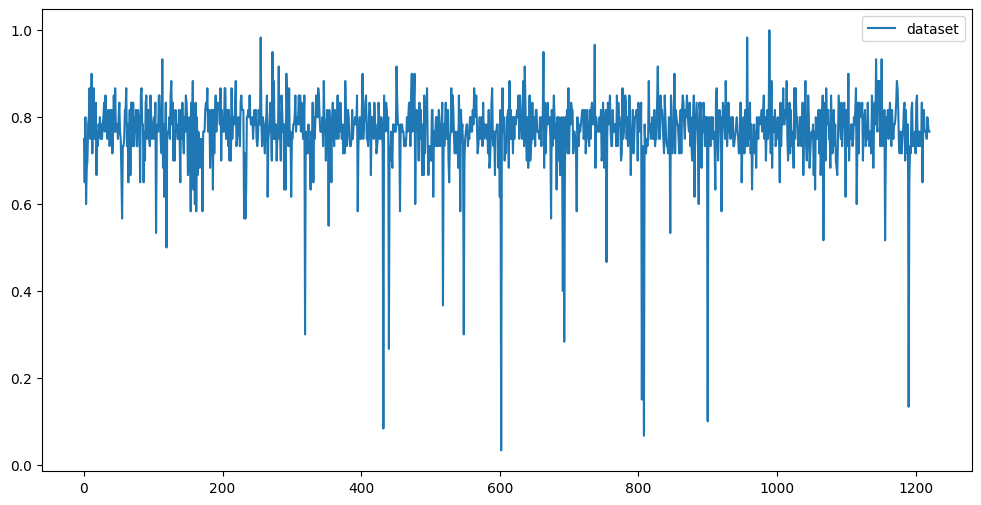

In [5]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('Q-data/speed_t4013_train.csv', usecols=[2], engine='python')
dataset = dataframe.values
stationary=verify_stationarity(dataset)
#dataframe=dataframe.diff(axis = 0, periods = 1)
#dataset = dataframe.dropna().values
dataset = dataset.astype('float32')
# normalize the dataset
print('dataset', dataset)
#dataset=dataset.dropna()
stationary = verify_stationarity(dataset)
scaler = MinMaxScaler(feature_range=(0, 1))

dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
std=numpy.std(train)
# reshape into X=t and Y=t+1
look_back = period_size
tw = step_size
multi = look_back // tw
trainX, trainY, trainXU, trainYU, trainXL, trainYL = create_dataset(train, look_back, tw)
testX, testY , testXU, testYU, testXL, testYL= create_dataset(test, look_back, tw)
print(trainX)
plt.figure(figsize=(12, 6))
# plt.plot(ts, label="passengers")
plt.plot(train, label="dataset")
# plt.plot(anomalies_array, label="difference")
# plt.plot(newdata['ewa'], label="ewa")
plt.legend(loc='best')

#plt.show()
alpha=identify_alpha(dataset)
print('alpha',alpha)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

trainXU = numpy.reshape(trainXU, (trainXU.shape[0], trainXU.shape[1], 1))
testXU = numpy.reshape(testXU, (testXU.shape[0], testXU.shape[1], 1))

trainXL = numpy.reshape(trainXL, (trainXL.shape[0], trainXL.shape[1], 1))
testXL = numpy.reshape(testXL, (testXL.shape[0], testXL.shape[1], 1))
print(trainX)


In [6]:
print("Splitting datasets into 3 parts for ensemble training...")

# Split q50 (median) data
trainX_parts = numpy.array_split(trainX, 3)
trainY_parts = numpy.array_split(trainY, 3)

# Split q10 (lower) data
trainXL_parts = numpy.array_split(trainXL, 3)
trainYL_parts = numpy.array_split(trainYL, 3)

# Split q90 (upper) data
trainXU_parts = numpy.array_split(trainXU, 3)
trainYU_parts = numpy.array_split(trainYU, 3)



Splitting datasets into 3 parts for ensemble training...


In [7]:
print("Splitting test datasets into 3 parts for ensemble testing...")

# Split q50 (median) data
testX_parts = numpy.array_split(testX, 3)
testY_parts = numpy.array_split(testY, 3)

# Split q10 (lower) data
testXL_parts = numpy.array_split(testXL, 3)
testYL_parts = numpy.array_split(testYL, 3)

# Split q90 (upper) data
testXU_parts = numpy.array_split(testXU, 3)
testYU_parts = numpy.array_split(testYU, 3)

Splitting test datasets into 3 parts for ensemble testing...


In [8]:
trainX_parts[0].shape

(357, 3, 1)

In [8]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(multi)

(1070, 3, 1)
(1070,)
(373, 3, 1)
3


In [9]:

modelq50_1 = Sequential()
modelq50_1.add(SimpleRNN(4, input_shape=(multi, 1)) )
modelq50_1.add(Dense(1))
modelq50_1.add(Swish(beta=1.5))
modelq50_1.add(Activation(Swish(beta=1.5)))
modelq50_1.compile(loss=losses.logcosh, optimizer='adam')
modelq50_1.fit(trainX_parts[0], trainY_parts[0], epochs=50, batch_size=1, verbose=2)

modelq10_1 = Sequential()
modelq10_1.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq10_1.add(Dense(1))
modelq10_1.add(Swish(beta=1.5))
modelq10_1.add(Activation(Swish(beta=1.5)))
modelq10_1.compile(loss=losses.logcosh, optimizer='adam')
modelq10_1.fit(trainXL_parts[0], trainYL_parts[0], epochs=50, batch_size=1, verbose=2)

modelq90_1 = Sequential()
modelq90_1.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq90_1.add(Dense(1))
modelq90_1.add(Swish(beta=1.5))
modelq90_1.add(Activation(Swish(beta=1.5)))
modelq90_1.compile(loss=losses.logcosh, optimizer='adam')
modelq90_1.fit(trainXU_parts[0], trainYU_parts[0], epochs=50, batch_size=1, verbose=2)

beta 1.5
beta 1.5
Epoch 1/50


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
357/357 - 2s - 5ms/step - loss: 0.0012
Epoch 2/50
357/357 - 0s - 1ms/step - loss: 2.7354e-05
Epoch 3/50
357/357 - 0s - 1ms/step - loss: 1.8410e-05
Epoch 4/50
357/357 - 0s - 1ms/step - loss: 1.8483e-05
Epoch 5/50
357/357 - 0s - 1ms/step - loss: 1.8590e-05
Epoch 6/50
357/357 - 0s - 1ms/step - loss: 1.8513e-05
Epoch 7/50
357/357 - 0s - 1ms/step - loss: 1.8595e-05
Epoch 8/50
357/357 - 0s - 1ms/step - loss: 1.8568e-05
Epoch 9/50
357/357 - 0s - 1ms/step - loss: 1.8704e-05
Epoch 10/50
357/357 - 0s - 1ms/step - loss: 1.8689e-05
Epoch 11/50
357/35

In [10]:

modelq50_2 = Sequential()
modelq50_2.add(SimpleRNN(4, input_shape=(multi, 1)) )
modelq50_2.add(Dense(1))
modelq50_2.add(Swish(beta=1.5))
modelq50_2.add(Activation(Swish(beta=1.5)))
modelq50_2.compile(loss=losses.logcosh, optimizer='adam')
modelq50_2.fit(trainX_parts[1], trainY_parts[1], epochs=50, batch_size=1, verbose=2)

modelq10_2 = Sequential()
modelq10_2.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq10_2.add(Dense(1))
modelq10_2.add(Swish(beta=1.5))
modelq10_2.add(Activation(Swish(beta=1.5)))
modelq10_2.compile(loss=losses.logcosh, optimizer='adam')
modelq10_2.fit(trainXL_parts[1], trainYL_parts[1], epochs=50, batch_size=1, verbose=2)

modelq90_2 = Sequential()
modelq90_2.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq90_2.add(Dense(1))
modelq90_2.add(Swish(beta=1.5))
modelq90_2.add(Activation(Swish(beta=1.5)))
modelq90_2.compile(loss=losses.logcosh, optimizer='adam')
modelq90_2.fit(trainXU_parts[1], trainYU_parts[1], epochs=50, batch_size=1, verbose=2)

beta 1.5
beta 1.5
Epoch 1/50
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
357/357 - 1s - 3ms/step - loss: 0.0638
Epoch 2/50
357/357 - 0s - 1ms/step - loss: 0.0065
Epoch 3/50
357/357 - 0s - 1ms/step - loss: 0.0029
Epoch 4/50
357/357 - 0s - 1ms/step - loss: 0.0015
Epoch 5/50
357/357 - 0s - 991us/step - loss: 8.9984e-04
Epoch 6/50
357/357 - 0s - 1ms/step - loss: 5.5178e-04
Epoch 7/50
357/357 - 0s - 1ms/step - loss: 3.4742e-04
Epoch 8/50
357/357 - 0s - 1ms/step - loss: 2.2213e-04
Epoch 9/50
357/357 - 1s - 2ms/step - loss: 1.4387e-04
Epoch 10/50
357/357 - 1s - 2ms/step - loss: 9.4834e-05
Epoch 11/50
357/357 - 0s - 1ms/step - loss: 6.4243e-05
Epoch 12/50
357/357 - 0s - 1ms/step - loss: 4.5921e-05
Epoch 13/50
357/357 - 0s - 1ms/step - loss: 3.5453e-05
Epoch 14/50
357/357 - 0s - 1ms/step - loss: 2.9652e-05
Epoch 15/50
357/357 - 0s - 975us/ste

In [11]:

modelq50_3 = Sequential()
modelq50_3.add(SimpleRNN(4, input_shape=(multi, 1)) )
modelq50_3.add(Dense(1))
modelq50_3.add(Swish(beta=1.5))
modelq50_3.add(Activation(Swish(beta=1.5)))
modelq50_3.compile(loss=losses.logcosh, optimizer='adam')
modelq50_3.fit(trainX_parts[2], trainY_parts[2], epochs=50, batch_size=1, verbose=2)

modelq10_3 = Sequential()
modelq10_3.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq10_3.add(Dense(1))
modelq10_3.add(Swish(beta=1.5))
modelq10_3.add(Activation(Swish(beta=1.5)))
modelq10_3.compile(loss=losses.logcosh, optimizer='adam')
modelq10_3.fit(trainXL_parts[2], trainYL_parts[2], epochs=50, batch_size=1, verbose=2)

modelq90_3 = Sequential()
modelq90_3.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq90_3.add(Dense(1))
modelq90_3.add(Swish(beta=1.5))
modelq90_3.add(Activation(Swish(beta=1.5)))
modelq90_3.compile(loss=losses.logcosh, optimizer='adam')
modelq90_3.fit(trainXU_parts[2], trainYU_parts[2], epochs=50, batch_size=1, verbose=2)

beta 1.5
beta 1.5
Epoch 1/50


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
356/356 - 1s - 4ms/step - loss: 0.0027
Epoch 2/50
356/356 - 0s - 1ms/step - loss: 1.1920e-04
Epoch 3/50
356/356 - 0s - 1ms/step - loss: 3.2359e-05
Epoch 4/50
356/356 - 1s - 2ms/step - loss: 2.8002e-05
Epoch 5/50
356/356 - 0s - 1ms/step - loss: 2.7826e-05
Epoch 6/50
356/356 - 0s - 1ms/step - loss: 2.7865e-05
Epoch 7/50
356/356 - 0s - 1ms/step - loss: 2.7736e-05
Epoch 8/50
356/356 - 0s - 1ms/step - loss: 2.8012e-05
Epoch 9/50
356/356 - 0s - 1ms/step - loss: 2.7961e-05
Epoch 10/50
356/356 - 1s - 2ms/step - loss: 2.7808e-05
Epoch 11/50
356/35

In [13]:
import numpy as np

# Example: your 3-model ensembles (rename if you use different variable names)
models_q50 = [modelq50_1, modelq50_2, modelq50_3]
models_q10 = [modelq10_1, modelq10_2, modelq10_3]
models_q90 = [modelq90_1, modelq90_2, modelq90_3]

# --- Helpers ---
def _to_scalar(y):
    y = np.array(y).reshape(-1)
    return float(y[0])

def _pad_or_truncate_to_len(x_1d, target_len):
    """x_1d: 1D np.array of length T. Return length == target_len.
       If T < target_len: pad with last value. If T > target_len: keep last target_len."""
    x_1d = np.asarray(x_1d, dtype=np.float32).reshape(-1)
    T = x_1d.shape[0]
    if T == target_len:
        return x_1d
    if T == 0:
        # make a tiny zero sequence (unlikely but safe)
        return np.zeros((target_len,), dtype=np.float32)
    if T > target_len:
        return x_1d[-target_len:]
    # pad with last value
    last = x_1d[-1]
    pad = np.full((target_len - T,), last, dtype=np.float32)
    return np.concatenate([x_1d, pad], axis=0)

def predict_on_slice_rnn(
    ds_slice, look_back, steps, lower_q, median_q, upper_q,
    model_q10, model_q50, model_q90, multi
):
    """
    ds_slice: 1D numpy array (scaled).
    Builds rolling windows of length look_back, converts each window into
    a sequence of per-chunk quantiles, then pads/truncates to length 'multi'
    and predicts with SimpleRNN models (input_shape=(multi,1)).
    """
    i, j = 0, look_back
    q10_preds, q50_preds, q90_preds = [], [], []
    pred_at_idx = []
    anomalies = []

    # We need at least one target (j+1) and enough points to form a sequence
    while (j + 1) < len(ds_slice):
        temp = ds_slice[i:j]  # window of length look_back

        # Build chunked quantiles for this window
        q50_vals, q10_vals, q90_vals = [], [], []
        for m in range(0, len(temp), steps):
            chunk = temp[m:m + steps]
            if chunk.size == 0:
                continue
            q50_vals.append(np.quantile(chunk, median_q))
            q10_vals.append(np.quantile(chunk, lower_q))
            q90_vals.append(np.quantile(chunk, upper_q))

        # Make sure we have something; otherwise advance
        if len(q50_vals) == 0:
            i += 1; j += 1
            continue

        # Pad/truncate EACH stream to exactly `multi`
        q50_seq = _pad_or_truncate_to_len(np.array(q50_vals, dtype=np.float32), multi)
        q10_seq = _pad_or_truncate_to_len(np.array(q10_vals, dtype=np.float32), multi)
        q90_seq = _pad_or_truncate_to_len(np.array(q90_vals, dtype=np.float32), multi)

        # Shape to (1, multi, 1) as expected by SimpleRNN(input_shape=(multi,1))
        X50 = q50_seq.reshape(1, multi, 1)
        X10 = q10_seq.reshape(1, multi, 1)
        X90 = q90_seq.reshape(1, multi, 1)

        # Predict
        q50p = _to_scalar(model_q50.predict(X50, verbose=0))
        q10p = _to_scalar(model_q10.predict(X10, verbose=0))
        q90p = _to_scalar(model_q90.predict(X90, verbose=0))

        q50_preds.append(q50p)
        q10_preds.append(q10p)
        q90_preds.append(q90p)
        pred_at_idx.append(j + 1)  # aligns with your anomaly check

        # Anomaly logic
        iqr = q90p - q10p
        ucl = q50p + 0.9 * iqr
        lcl = q50p - 0.9 * iqr
        point = ds_slice[j + 1]
        if (point > ucl) or (point < lcl):
            anomalies.append(point)

        i += 1
        j += 1

    return (
        np.array(q10_preds, dtype=np.float32),
        np.array(q50_preds, dtype=np.float32),
        np.array(q90_preds, dtype=np.float32),
        np.array(pred_at_idx, dtype=np.int64),
        np.array(anomalies, dtype=np.float32),
    )

# --- Prepare test thirds and run the 3-model ensemble per quantile ---
# dataset is your scaled 1D array
test_start, test_end = 0, len(dataset)
N = test_end - test_start
split1 = test_start + N // 3
split2 = test_start + 2 * (N // 3)
slices = [(test_start, split1), (split1, split2), (split2, test_end)]

all_q10, all_q50, all_q90 = [], [], []
all_pos = []
all_anoms = []

for k, (s, e) in enumerate(slices):
    # Need enough length for at least one target and to form a sequence.
    # Minimum: look_back + 2 (because we access j+1), but we’ll still pad to `multi`.
    if e - s <= (look_back + 1):
        continue

    ds_slice = dataset[s:e].astype(np.float32).reshape(-1)
    q10p, q50p, q90p, pos, anoms = predict_on_slice_rnn(
        ds_slice=ds_slice,
        look_back=look_back,
        steps=tw,  # your "steps"
        lower_q=lower_q_threshold,
        median_q=median_q_threshold,
        upper_q=upper_q_threshold,
        model_q10=models_q10[k],
        model_q50=models_q50[k],
        model_q90=models_q90[k],
        multi=multi,   # <- CRUCIAL: matches your SimpleRNN input_shape
    )
    all_q10.append(q10p); all_q50.append(q50p); all_q90.append(q90p)
    all_pos.append(pos + s)          # map back to absolute indices
    all_anoms.append(anoms)

# Concatenate the 3 parts
q10_pred_full = np.concatenate(all_q10) if all_q10 else np.array([], dtype=np.float32)
q50_pred_full = np.concatenate(all_q50) if all_q50 else np.array([], dtype=np.float32)
q90_pred_full = np.concatenate(all_q90) if all_q90 else np.array([], dtype=np.float32)
pred_pos_full  = np.concatenate(all_pos) if all_pos else np.array([], dtype=np.int64)
anomalies_array = np.concatenate(all_anoms) if all_anoms else np.array([], dtype=np.float32)

# Optional inverse-transform the anomaly values to original scale
if anomalies_array.size > 0:
    anomalies_array = scaler.inverse_transform(anomalies_array.reshape(-1, 1)).ravel()


beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000029AD651A8A0>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel objec

#predictions: 2042
#anomalies (flagged): 121
t=  151 | y=47.0000 | q10=57.0546 | q50=62.1219 | q90=66.7686 | LCL=53.3793 | UCL=70.8644 | anom=True
t=  152 | y=52.0000 | q10=57.0546 | q50=62.0841 | q90=66.7689 | LCL=53.3413 | UCL=70.8270 | anom=True
t=  153 | y=52.0000 | q10=56.9860 | q50=62.0841 | q90=66.7689 | LCL=53.2795 | UCL=70.8887 | anom=True
t=  154 | y=58.0000 | q10=56.9860 | q50=62.0841 | q90=66.7689 | LCL=53.2795 | UCL=70.8887 | anom=False
t=  155 | y=52.0000 | q10=56.9860 | q50=62.0458 | q90=66.7689 | LCL=53.2412 | UCL=70.8504 | anom=True
t=  156 | y=55.0000 | q10=57.0234 | q50=62.0458 | q90=66.7692 | LCL=53.2746 | UCL=70.8170 | anom=False
t=  157 | y=47.0000 | q10=57.0626 | q50=62.0084 | q90=66.7692 | LCL=53.2724 | UCL=70.7443 | anom=True
t=  158 | y=53.0000 | q10=57.0482 | q50=61.9691 | q90=66.7692 | LCL=53.2202 | UCL=70.7179 | anom=True
t=  159 | y=49.0000 | q10=57.0098 | q50=61.9292 | q90=66.7692 | LCL=53.1458 | UCL=70.7126 | anom=True
t=  160 | y=49.0000 | q10=57.0057 |

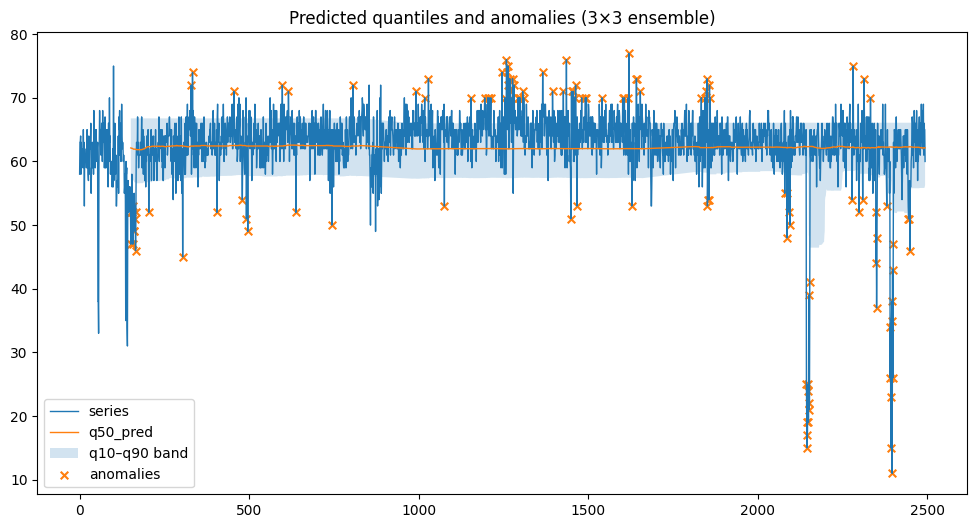


[Index-based] TP, FP, FN: 0 121 2
[Index-based] Precision: 0.0 Recall: 0.0

[Value-based] TP, FP, FN: 2 35 0
[Value-based] Precision: 0.05405405405405406 Recall: 1.0


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import builtins
# --- 1) Optional: inverse-transform predictions for human-readable plots ---
def inv(x):
    if x is None or len(x) == 0: 
        return np.array([])
    return scaler.inverse_transform(np.array(x).reshape(-1,1)).ravel()

dataset_inv = scaler.inverse_transform(dataset.reshape(-1,1)).ravel()
q10_inv = inv(q10_pred_full)
q50_inv = inv(q50_pred_full)
q90_inv = inv(q90_pred_full)

# --- 2) Build a tidy table of results (aligned by pred_pos_full) ---
# NOTE: pred_pos_full are the dataset indices where each prediction applies
res_idx = pred_pos_full.astype(int)
ucl_inv = q50_inv + 0.9*(q90_inv - q10_inv)
lcl_inv = q50_inv - 0.9*(q90_inv - q10_inv)
y_true_inv = dataset_inv[res_idx]

# Flags using inverse-scale (same logic you used)
flags = (y_true_inv > ucl_inv) | (y_true_inv < lcl_inv)

print(f"#predictions: {len(res_idx)}")
print(f"#anomalies (flagged): {int(flags.sum())}")

# Peek first 10 rows
for k in range(builtins.min(10, len(res_idx))):
    print(f"t={res_idx[k]:5d} | y={y_true_inv[k]:.4f} | q10={q10_inv[k]:.4f} | "
          f"q50={q50_inv[k]:.4f} | q90={q90_inv[k]:.4f} | "
          f"LCL={lcl_inv[k]:.4f} | UCL={ucl_inv[k]:.4f} | anom={bool(flags[k])}")

# --- 3) Plot series + predicted bands (only where we have preds) ---
plt.figure(figsize=(12,6))
plt.plot(dataset_inv, label="series", linewidth=1)
plt.plot(res_idx, q50_inv, label="q50_pred", linewidth=1)
plt.fill_between(res_idx, q10_inv, q90_inv, alpha=0.2, label="q10–q90 band")
plt.scatter(res_idx[flags], y_true_inv[flags], marker='x', s=30, label="anomalies")
plt.legend(loc="best")
plt.title("Predicted quantiles and anomalies (3×3 ensemble)")
plt.show()

# --- 4) Metrics (choose index-based or value-based ground truth) ---

# If your ground truth are *indices* of anomalies:
gt_idx = np.array([15, 11])  # replace with your actual indices
pred_idx = res_idx[flags]
tp_idx = np.intersect1d(pred_idx, gt_idx)
fp_idx = np.setdiff1d(pred_idx, gt_idx)
fn_idx = np.setdiff1d(gt_idx, pred_idx)
precision_idx = len(tp_idx) / (len(tp_idx) + len(fp_idx)) if (len(tp_idx)+len(fp_idx)) else 0.0
recall_idx = len(tp_idx) / (len(tp_idx) + len(fn_idx)) if (len(tp_idx)+len(fn_idx)) else 0.0
print("\n[Index-based] TP, FP, FN:", len(tp_idx), len(fp_idx), len(fn_idx))
print("[Index-based] Precision:", precision_idx, "Recall:", recall_idx)

# If your ground truth are *values* (like your earlier code):
gt_vals = np.array([15, 11])  # replace if you truly compare actual values
pred_vals = anomalies_array  # already inverse-transformed values
if pred_vals.size > 0:
    uniq_pred_vals = np.unique(pred_vals.astype(object))
    tp_vals = np.intersect1d(uniq_pred_vals, gt_vals)
    fp_vals = np.setdiff1d(uniq_pred_vals, gt_vals)
    fn_vals = np.setdiff1d(gt_vals, uniq_pred_vals)
    precision_vals = len(tp_vals) / (len(tp_vals) + len(fp_vals)) if (len(tp_vals)+len(fp_vals)) else 0.0
    recall_vals = len(tp_vals) / (len(tp_vals) + len(fn_vals)) if (len(tp_vals)+len(fn_vals)) else 0.0
    print("\n[Value-based] TP, FP, FN:", len(tp_vals), len(fp_vals), len(fn_vals))
    print("[Value-based] Precision:", precision_vals, "Recall:", recall_vals)
else:
    print("\n[Value-based] No predicted anomaly values to compare.")


In [19]:
accuracy = (len(tp_vals) + (1670 - len(tp_vals) - len(fp_vals) - len(fn_vals))) / 1670
print("Accuracy:")
print(accuracy)


Accuracy:
0.9790419161676647


# ----------------------------
## ----------------------------

In [16]:
def predict_ensemble(models, input_data):
    """Average predictions from multiple models for robust inference"""
    predictions = [model.predict(input_data, verbose=0) for model in models]
    return numpy.mean(predictions, axis=0)

# Group models by quantile for ensemble prediction
model_q50 = [modelq50_1, modelq50_2, modelq50_3]
model_q10 = [modelq10_1, modelq10_2, modelq10_3]
model_q90 = [modelq90_1, modelq90_2, modelq90_3]

In [ ]:
# %%
# INFERENCE WITH PROPER ENSEMBLE MODELS
i = 0
j = look_back
actual_quantile_interval = []
steps = tw
positive = True
anomalies = []
anomaly_indices = []
finalres_q10 = []
finalres_q90 = []

# Load test data (reusing same scaler from training)
dataframe = read_csv('Q-data/speed_t4013_labelled.csv', usecols=[2], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset = scaler.transform(dataset)  # Use transform, not fit_transform
ts = dataset
ts_accumulate = []
comparison_dataset = []

print(f"Starting inference on {len(dataset)} data points...")

while j <= len(dataset):
    q50_array = []
    q10_array = []
    q90_array = []

    temp = dataset[i:j]
    actual_quantile_interval.append(
        numpy.absolute(numpy.quantile(dataset[i + 1:j + 1], lower_q_threshold) - 
                      numpy.quantile(dataset[i + 1:j + 1], median_q_threshold)))

    # Extract quantile features
    for m in range(0, len(temp), steps):
        q50array = []
        q10array = []
        q90array = []
        
        q50 = numpy.quantile(temp[m:m + steps], median_q_threshold)
        q50array.append(q50)
        q50_array.append(q50array)

        q90 = numpy.quantile(temp[m:m + steps], upper_q_threshold)
        q90array.append(q90)
        q90_array.append(q90array)

        q10 = numpy.quantile(temp[m:m + steps], lower_q_threshold)
        q10array.append(q10)
        q10_array.append(q10array)

    # Prepare input arrays
    final_q50_array = [q50_array]
    final_q10_array = [q10_array]
    final_q90_array = [q90_array]

    # USE ENSEMBLE PREDICTION (FIXED)
    q50_predict = predict_ensemble(model_q50, final_q50_array)
    q10_predict = predict_ensemble(model_q10, final_q10_array)
    q90_predict = predict_ensemble(model_q90, final_q90_array)

    # Anomaly detection
    if j + 1 < len(dataset):
        iqr = q90_predict - q10_predict
        ucl = q50_predict + 0.9 * iqr
        lcl = q50_predict - 0.9 * iqr
        diff = q50_predict - dataset[j + 1]
        
        if dataset[j + 1] > ucl or dataset[j + 1] < lcl:
            anomalies.append(dataset[j + 1])
            anomaly_indices.append(j + 1)

    j = j + 1
    i = i + 1

# Post-process anomalies
anomalies_array = []
for h in range(len(anomalies)):
    anomalies_array.append(anomalies[h])

anomalies_array = scaler.inverse_transform(anomalies_array)

print('Detected anomalies (original scale):', anomalies_array.flatten())
print('Number of anomalies detected:', len(anomalies_array))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(dataset, label="Test Dataset (Normalized)", alpha=0.7)

if len(anomaly_indices) > 0:
    plt.scatter(anomaly_indices, [dataset[idx] for idx in anomaly_indices], 
                color='red', s=100, marker='x', 
                label=f'Detected Anomalies ({len(anomaly_indices)})', zorder=5)

plt.xlabel('Time Step')
plt.ylabel('Normalized Speed')
plt.title('Anomaly Detection Results')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Evaluation metrics
anomaly_res = [15, 11]  # Ground truth
anomalies = numpy.unique(anomalies_array)

print('\nEvaluation:')
print('Detected unique anomalies:', anomalies.flatten())
print('Ground truth:', anomaly_res)

truep = numpy.intersect1d(anomalies, numpy.array(anomaly_res))
tp = len(truep)
fp = len(anomalies) - len(truep)
fn = len(anomaly_res) - len(truep)
tn = 1670 - tp - fp - fn

print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

if tp + fp > 0:
    precision = tp / (tp + fp)
    print(f"Precision: {precision:.4f}")
else:
    precision = 0
    print("Precision: undefined")

if tp + fn > 0:
    recall = tp / (tp + fn)
    print(f"Recall: {recall:.4f}")
else:
    recall = 0
    print("Recall: undefined")

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"F1-Score: {f1_score:.4f}")
else:
    print("F1-Score: 0.0000")

In [ ]:
# trainmeanPredict = modelmean.predict(trainX)
# testmeanPredict = modelmean.predict(testX)
# trainstdPredict = modelstd.predict(trainX)
# teststdPredict = modelstd.predict(testX)
# print('trainmeanPredict',trainmeanPredict)
i = 0
j = look_back
actual_quantile_interval = []
steps = tw
positive = True
anomalies=[]
finalres_q10 = []
finalres_q90 = []
dataframe = read_csv('Q-data/speed_t4013_labelled.csv', usecols=[2], engine='python')
dataset = dataframe.values
dataset = scaler.transform(dataset)
ts = dataset
ts_accumulate=[]
comparison_dataset=[]
while j <= len(dataset):
    q50_array = []
    q10_array = []
    q90_array = []


    temp = dataset[i:j]
    actual_quantile_interval.append(
        numpy.absolute(numpy.quantile(dataset[i + 1:j + 1], lower_q_threshold) - numpy.quantile(dataset[i + 1:j + 1], median_q_threshold)))
    print('print here', temp)

    for m in range(0, len(temp), steps):
        q50array = []
        q10array = []
        q90array = []
        q50 = numpy.quantile(temp[m:m + steps], median_q_threshold)
        q50array.append(q50)
        q50_array.append(q50array)

        q90 = numpy.quantile(temp[m:m + steps], upper_q_threshold)
        q90array.append(q90)
        q90_array.append(q90array)

        q10 = numpy.quantile(temp[m:m + steps], lower_q_threshold)
        q10array.append(q10)
        q10_array.append(q10array)

    # print('stdarray1', std_array)
    # std_array = numpy.array(std_array)
    # print('stdarray2', std_array)
    # std_array = numpy.reshape(std_array, (std_array.shape[0],std_array.shape[1], 1))
    # print('stdarray3', std_array)
    # print('avg_array',avg_array)
    # avg_array = numpy.array(avg_array)
    # avg_array = numpy.reshape(avg_array, (avg_array.shape[0],1, 1))
    final_q50_array = []
    final_q50_array.append(q50_array)
    print('final_q10_array', final_q50_array)
    final_q10_array = []
    final_q10_array.append(q10_array)

    final_q90_array = []
    final_q90_array.append(q90_array)


    
    q50_predict = modelq50.predict(final_q50_array)
    print('q50_predict', q50_predict)
    q10_predict = modelq10.predict(final_q10_array)
    q90_predict = modelq90.predict(final_q90_array)

    if j+1 < len(dataset) :
        iqr=q90_predict-q10_predict
        ucl=q50_predict+.9*iqr
        lcl=q50_predict-.9*iqr
        diff=q50_predict-dataset[j+1]
        if dataset[j+1]>ucl or dataset[j+1]<lcl:
            anomalies.append(dataset[j+1])
        #print('data',dataset[j+1],'diff',diff)

        #comparison_dataset.append(dataset[j+1])
        #dataset=numpy.delete(dataset,j+1)
        #print('length',len(dataset))
    #finalres_q10.append(q10_predict)
    #finalres_q90.append(q90_predict)

    j = j + 1
    i = i + 1

# print('finalres',finalres)
'''prediction_array_q10 = []
prediction_array_q90 = []'''
anomalies_array=[]

for h in range(len(anomalies)):
    internal = anomalies[h]
    internal_array = []
    #internal_array.append(internal[0])
    anomalies_array.append(internal)
anomalies_array = scaler.inverse_transform(anomalies_array)
#comparison_dataset=scaler.inverse_transform(comparison_dataset)
#print(anomalies_array)
print('anomaly_iden', anomalies_array)
print('anomaly_iden size', len(anomalies_array))
'''for itr in range(len(anomalies_array)):
    print('data',comparison_dataset[itr],'diff',anomalies_array[itr])
print('anomaly length',len(anomalies_array))'''
'''ts_accumulate_another=[]
for h in range(len(finalres_q10)):
    internal = finalres_q10[h]
    internal_q90 = finalres_q90[h]
    prediction_array_q10.append(internal[0])
    prediction_array_q90.append(internal_q90[0])
for g in range(len(ts_accumulate)):
    internal=[]
    internal.append(ts_accumulate[g])
    #internal_q90 = finalres_q90[h]
    ts_accumulate_another.append(internal)
finalres_q10 = scaler.inverse_transform(prediction_array_q10)
finalres_q90 = scaler.inverse_transform(prediction_array_q90)
#print('finalres', finalres_q10)'''
'''trunc_finalres = []
for g in range(len(finalres)):
    trunc_finalres.append(finalres[g])'''
'''ts = ts[look_back:]
ts = scaler.inverse_transform(ts)
ts_accumulate=scaler.inverse_transform(ts_accumulate_another)
print('lenght', len(ts_accumulate), 'actual_quantile_interval', len(finalres_q10))'''
'''ts_array = []
for g in range(len(ts)):
    ts_array.append(ts[g])'''
'''finalres_q10_array=[]
finalres_q90_array=[]
for g in range(len(finalres_q10)-1):
    finalres_q10_array.append(finalres_q10[g])
    finalres_q90_array.append(finalres_q90[g])
prediction_errors = []'''
# for y in range(len(finalres_q10_array)):
#    print('ts_accumulate',ts_accumulate[y], 'finalres_q10_array', finalres_q10_array[y], 'finalres_q90_array', finalres_q90_array[y])
    #prediction_errors.append(numpy.absolute(actual_quantile_interval[y] - trunc_finalres[y]))
# testScore = math.sqrt(mean_squared_error(ts, trunc_finalres))
# print('Test Score: %.2f RMSE' % (testScore))
'''anomalies = identify_anomaly(anomalies_array)
print('anomaly_iden', anomalies)
print('anomaly_iden size', len(anomalies))
print(intersection(anomalies, anomaly_res))'''
plt.figure(figsize=(12, 6))
#plt.plot(ts, label="passengers")
plt.plot(dataset, label="dataset")
#plt.plot(anomalies_array, label="difference")
#plt.plot(newdata['ewa'], label="ewa")
plt.legend(loc='best')

plt.show()


anomaly_res =[15,11]
anomalies = numpy.unique(anomalies_array)
print('anomaly_iden', anomalies)
print('anomaly_iden size', len(anomalies))
print('ani', anomaly_res)
truep = (numpy.intersect1d(anomalies, numpy.array(anomaly_res)))
print("TP:")
tp = len(truep)
print(tp)
print("FP:")
fp = (len(anomalies) - len(truep))
print(fp)
print("FN:")
fn = len(anomaly_res) - len(truep)
print(fn)
print("TN:")
print(1670-tp-fp-fn)
#1670 - datapoints in yahoo8
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision:")
print(precision)
print("Recall:")
print(recall)